In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add project root to path (avoids jax import issues from testing/)
parent_dir = Path.cwd().resolve()
if parent_dir.name == 'testing':
    parent_dir = parent_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
os.chdir(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jax
import jax.numpy as jnp
import jax.random as random
import time

import jax_gibbs as gs_jax
import utils
import validation

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Configuration
T_gibbs = 50000
T_kde = 50000

# Test parameters
ks = [1.0, 2.0, 3.0, 5.0]
ms = [10, 20, 50, 100]     # Different m values
mu_true = 2.0

# Common sampler parameters
base_params = {
    'mu_true': mu_true,
    'prior_mean': 0.0,
    'prior_std': 10.0,
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.03,
}

print(f"Configuration:")
print(f"  Gibbs chain length: T = {T_gibbs:,}")
print(f"  KDE simulations: {T_kde:,}")
print(f"  Testing k values: {ks}")
print(f"  Testing m values: {ms}")
print(f"  True μ = {mu_true}")


Configuration:
  Gibbs chain length: T = 50,000
  KDE simulations: 50,000
  Testing k values: [1.0, 2.0, 3.0, 5.0]
  Testing m values: [10, 20, 50, 100]
  True μ = 2.0


## Part 1: Focus on k=1 (Cauchy)


In [3]:
# Part 1: k=1 (Cauchy), m=100
k_cauchy = 1.0
m_test = 100

print("Running Gibbs + KDE...")
single_run = validation.run_single_gibbs_kde(
    k=k_cauchy, m=m_test, mu_true=mu_true,
    T_gibbs=T_gibbs, T_kde=T_kde, base_params=base_params,
)
data = single_run['data']
mle = single_run['mle']
gibbs_results = single_run['gibbs_results']
mu_chain_gibbs = single_run['mu_chain_gibbs']
mu_chain_post_burnin = single_run['mu_chain_post_burnin']
kde_posterior_pdf = single_run['kde_posterior_pdf']
burnin = single_run['burnin']

print(f"k = {k_cauchy} (Cauchy), m = {m_test}")
print(f"Generated data: {data}")
print(f"Calculated MLE μ* = {mle:.4f}")
print(f"True μ = {mu_true:.4f}")


Running Gibbs + KDE...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:36<00:00, 519.36it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2009
Z_i Acceptance Rate: 0.7782

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001
k = 1.0 (Cauchy), m = 100
Generated data: [-2.25919339e+00 -2.84229171e-02  2.30742177e+00  3.59600687e-01
  1.92624690e+00 -1.05531304e+01  5.60238592e+00  2.96940796e-01
 -2.59354836e+00  2.42935263e+00  9.29453975e-01  3.32984763e+00
  1.27689337e+00  8.55287487e+00  1.94661019e-03  4.48162878e-01
  1.76162236e+00  4.39604217e+00  2.01117711e+00  4.27076075e+00
  2.71600772e+00  2.14838349e+00  3.01937975e+00  2.55658290e+00
  8.32554551e+00  3.81411892e+00  8.11370782e-01 -1.71359191e+00
  2.32816188e+00  1.31207002e+00  1.12543423e+00  2.73006442e+00
  4.87648864e+00 -9.28388088e-01  3.38096899e+00 -5.48

/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


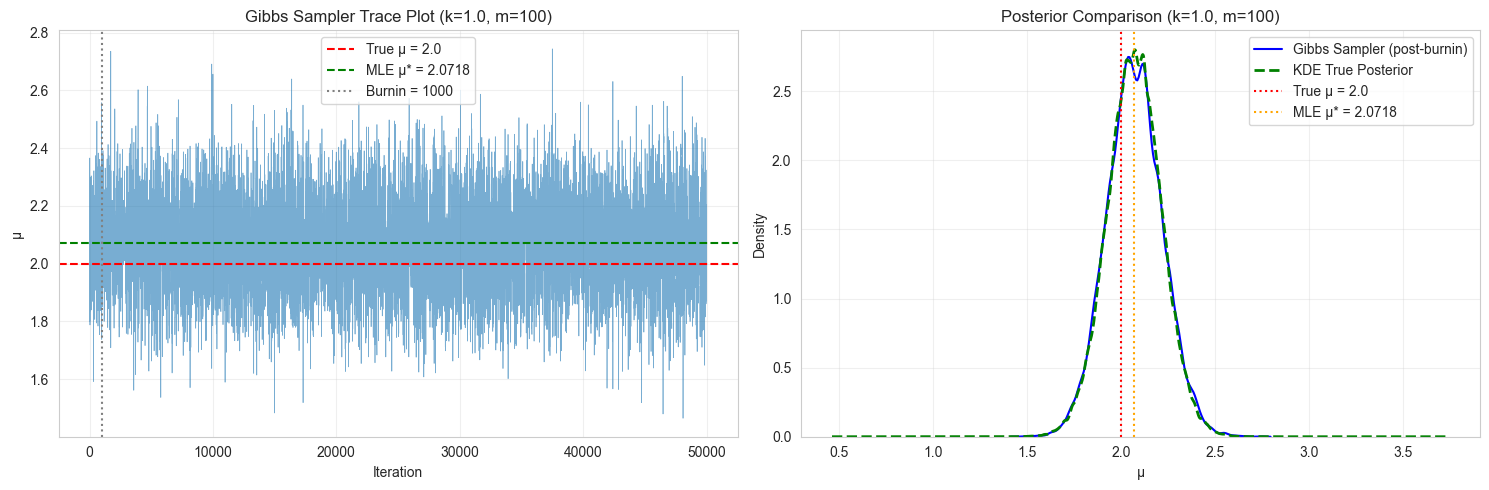


Gibbs Sampler Statistics (post-burnin):
  Mean: 2.0719
  Std:  0.1474
  Variance: 0.0217


In [4]:
# Compare Gibbs sampler with KDE

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Trace plot
axes[0].plot(mu_chain_gibbs, alpha=0.6, linewidth=0.5)
axes[0].axhline(mu_true, color='red', linestyle='--', label=f'True μ = {mu_true}')
axes[0].axhline(mle, color='green', linestyle='--', label=f'MLE μ* = {mle:.4f}')
axes[0].axvline(burnin, color='gray', linestyle=':', label=f'Burnin = {burnin}')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('μ')
axes[0].set_title(f'Gibbs Sampler Trace Plot (k={k_cauchy}, m={m_test})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density comparison
mu_grid = np.linspace(mu_chain_post_burnin.min() - 1, mu_chain_post_burnin.max() + 1, 1000)
kde_pdf_values = kde_posterior_pdf(mu_grid)

sns.kdeplot(mu_chain_post_burnin, label='Gibbs Sampler (post-burnin)', ax=axes[1], color='blue')
axes[1].plot(mu_grid, kde_pdf_values, label='KDE True Posterior', color='green', linestyle='--', linewidth=2)
axes[1].axvline(mu_true, color='red', linestyle=':', label=f'True μ = {mu_true}')
axes[1].axvline(mle, color='orange', linestyle=':', label=f'MLE μ* = {mle:.4f}')
axes[1].set_xlabel('μ')
axes[1].set_ylabel('Density')
axes[1].set_title(f'Posterior Comparison (k={k_cauchy}, m={m_test})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'gibbs_vs_kde_k{int(k_cauchy)}_m{m_test}.pdf', dpi=300)
plt.show()

# Print statistics
print(f"\nGibbs Sampler Statistics (post-burnin):")
print(f"  Mean: {mu_chain_post_burnin.mean():.4f}")
print(f"  Std:  {mu_chain_post_burnin.std():.4f}")
print(f"  Variance: {mu_chain_post_burnin.var():.4f}")


## Part 2: Empirical Variance Analysis for Different k and m

The empirical variance of the posterior given the MLE for different k and m values.


In [5]:
# Variance sweep across (k, m) combinations
variance_sweep_results = validation.run_variance_sweep(
    ks=ks, ms=ms, mu_true=mu_true,
    T_gibbs=T_gibbs, T_kde=T_kde, base_params=base_params,
    seed=0, verbose=True,
)



Processing k=1.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:42<00:00, 1167.48it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.5414
Z_i Acceptance Rate: 0.4866
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 87.382937
  KDE variance:   0.554383
  Variance ratio (Gibbs/KDE): 157.6220
  Time - Gibbs: 42.86s, KDE: 10.66s

Processing k=1.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:48<00:00, 1039.21it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4223
Z_i Acceptance Rate: 0.7735
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 0.147802
  KDE variance:   0.116650
  Variance ratio (Gibbs/KDE): 1.2671
  Time - Gibbs: 48.15s, KDE: 9.80s

Processing k=1.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:04<00:00, 773.84it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2799
Z_i Acceptance Rate: 0.7783
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001


/Users/shlokmishra/code/student_t_mle/utils.py:88: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, _ = quad(lambda mu: np.exp(log_unnorm(mu)), -np.inf, np.inf)


  Gibbs variance: 0.044608
  KDE variance:   0.042619
  Variance ratio (Gibbs/KDE): 1.0467
  Time - Gibbs: 64.65s, KDE: 10.91s

Processing k=1.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:32<00:00, 543.27it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2009
Z_i Acceptance Rate: 0.7802
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = 0.001
  Gibbs variance: 0.021308
  KDE variance:   0.020607
  Variance ratio (Gibbs/KDE): 1.0340
  Time - Gibbs: 92.04s, KDE: 8.02s

Processing k=2.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:40<00:00, 1243.82it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4958
Z_i Acceptance Rate: 0.7109
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.226478
  KDE variance:   0.191085
  Variance ratio (Gibbs/KDE): 1.1852
  Time - Gibbs: 40.20s, KDE: 7.98s

Processing k=2.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:46<00:00, 1075.34it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3781
Z_i Acceptance Rate: 0.7201
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.095813
  KDE variance:   0.088572
  Variance ratio (Gibbs/KDE): 1.0818
  Time - Gibbs: 46.50s, KDE: 7.08s

Processing k=2.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:02<00:00, 796.74it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2492
Z_i Acceptance Rate: 0.7260
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.033806
  KDE variance:   0.034803
  Variance ratio (Gibbs/KDE): 0.9714
  Time - Gibbs: 62.76s, KDE: 6.72s

Processing k=2.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:32<00:00, 542.25it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1789
Z_i Acceptance Rate: 0.7245
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.017365
  KDE variance:   0.017057
  Variance ratio (Gibbs/KDE): 1.0180
  Time - Gibbs: 92.22s, KDE: 7.27s

Processing k=3.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:40<00:00, 1226.93it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4680
Z_i Acceptance Rate: 0.7206
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.180557
  KDE variance:   0.163723
  Variance ratio (Gibbs/KDE): 1.1028
  Time - Gibbs: 40.75s, KDE: 5.82s

Processing k=3.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:46<00:00, 1071.23it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3601
Z_i Acceptance Rate: 0.7286
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.081361
  KDE variance:   0.077937
  Variance ratio (Gibbs/KDE): 1.0439
  Time - Gibbs: 46.68s, KDE: 6.65s

Processing k=3.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:02<00:00, 795.13it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2379
Z_i Acceptance Rate: 0.7317
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.031372
  KDE variance:   0.030925
  Variance ratio (Gibbs/KDE): 1.0145
  Time - Gibbs: 62.89s, KDE: 6.29s

Processing k=3.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:30<00:00, 550.10it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1688
Z_i Acceptance Rate: 0.7321
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.015245
  KDE variance:   0.015348
  Variance ratio (Gibbs/KDE): 0.9933
  Time - Gibbs: 90.90s, KDE: 6.29s

Processing k=5.0, m=10
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:41<00:00, 1214.48it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.4414
Z_i Acceptance Rate: 0.8022
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.143954
  KDE variance:   0.139025
  Variance ratio (Gibbs/KDE): 1.0354
  Time - Gibbs: 41.17s, KDE: 6.43s

Processing k=5.0, m=20
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [00:45<00:00, 1096.47it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.3312
Z_i Acceptance Rate: 0.7994
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.069412
  KDE variance:   0.068842
  Variance ratio (Gibbs/KDE): 1.0083
  Time - Gibbs: 45.60s, KDE: 6.47s

Processing k=5.0, m=50
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:02<00:00, 803.68it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.2201
Z_i Acceptance Rate: 0.8036
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.026188
  KDE variance:   0.027215
  Variance ratio (Gibbs/KDE): 0.9623
  Time - Gibbs: 62.22s, KDE: 5.46s

Processing k=5.0, m=100
  Running Gibbs sampler (T=50,000)...


Running Gibbs Sampler: 100%|██████████| 50000/50000 [01:31<00:00, 544.03it/s]



--- Sampling Complete ---
Mu Acceptance Rate: 0.1567
Z_i Acceptance Rate: 0.8046
  Computing KDE posterior (50,000 simulations)...

--- Computing Benchmark KDE from 50000 simulations ---
  Processing simulation 10000/50000...
  Processing simulation 20000/50000...
  Processing simulation 30000/50000...
  Processing simulation 40000/50000...
  Processing simulation 50000/50000...
Fitting KDE to MLE samples using bw_method = scott
  Gibbs variance: 0.013072
  KDE variance:   0.013637
  Variance ratio (Gibbs/KDE): 0.9586
  Time - Gibbs: 91.91s, KDE: 6.06s


In [6]:
# Create summary table
import pandas as pd

df_results = pd.DataFrame(variance_sweep_results)
print("\n" + "="*80)
print("SUMMARY: Empirical Variance Analysis")
print("="*80)
print(df_results.to_string(index=False))



SUMMARY: Empirical Variance Analysis
  k   m  gibbs_variance  kde_variance  gibbs_mean  kde_mean      mle  time_gibbs  time_kde
1.0  10       87.382937      0.554383   -7.639908  2.045585 2.063652   42.856341 10.663255
1.0  20        0.147802      0.116650    1.938346  1.945856 1.946915   48.148240  9.800279
1.0  50        0.044608      0.042619    1.583177  1.584266 1.586572   64.647662 10.911577
1.0 100        0.021308      0.020607    2.011031  2.008906 2.010608   92.044114  8.021969
2.0  10        0.226478      0.191085    1.842952  1.853925 1.857898   40.201806  7.982559
2.0  20        0.095813      0.088572    1.611321  1.613298 1.613111   46.500262  7.082135
2.0  50        0.033806      0.034803    1.719612  1.720349 1.721247   62.761811  6.716941
2.0 100        0.017365      0.017057    2.011298  2.011272 2.011085   92.221333  7.271424
3.0  10        0.180557      0.163723    1.570055  1.568923 1.570248   40.754675  5.820812
3.0  20        0.081361      0.077937    1.693084  1

### Gibbs validation

Gibbs sampler provides a reliable approximation of the posterior given MLE: variance ratios (Gibbs/KDE) are close to 1 for m ≥ 20. For k=1 (Cauchy) with small m (e.g. m=10), Gibbs can be unstable; for m ≥ 20 it tracks KDE well.

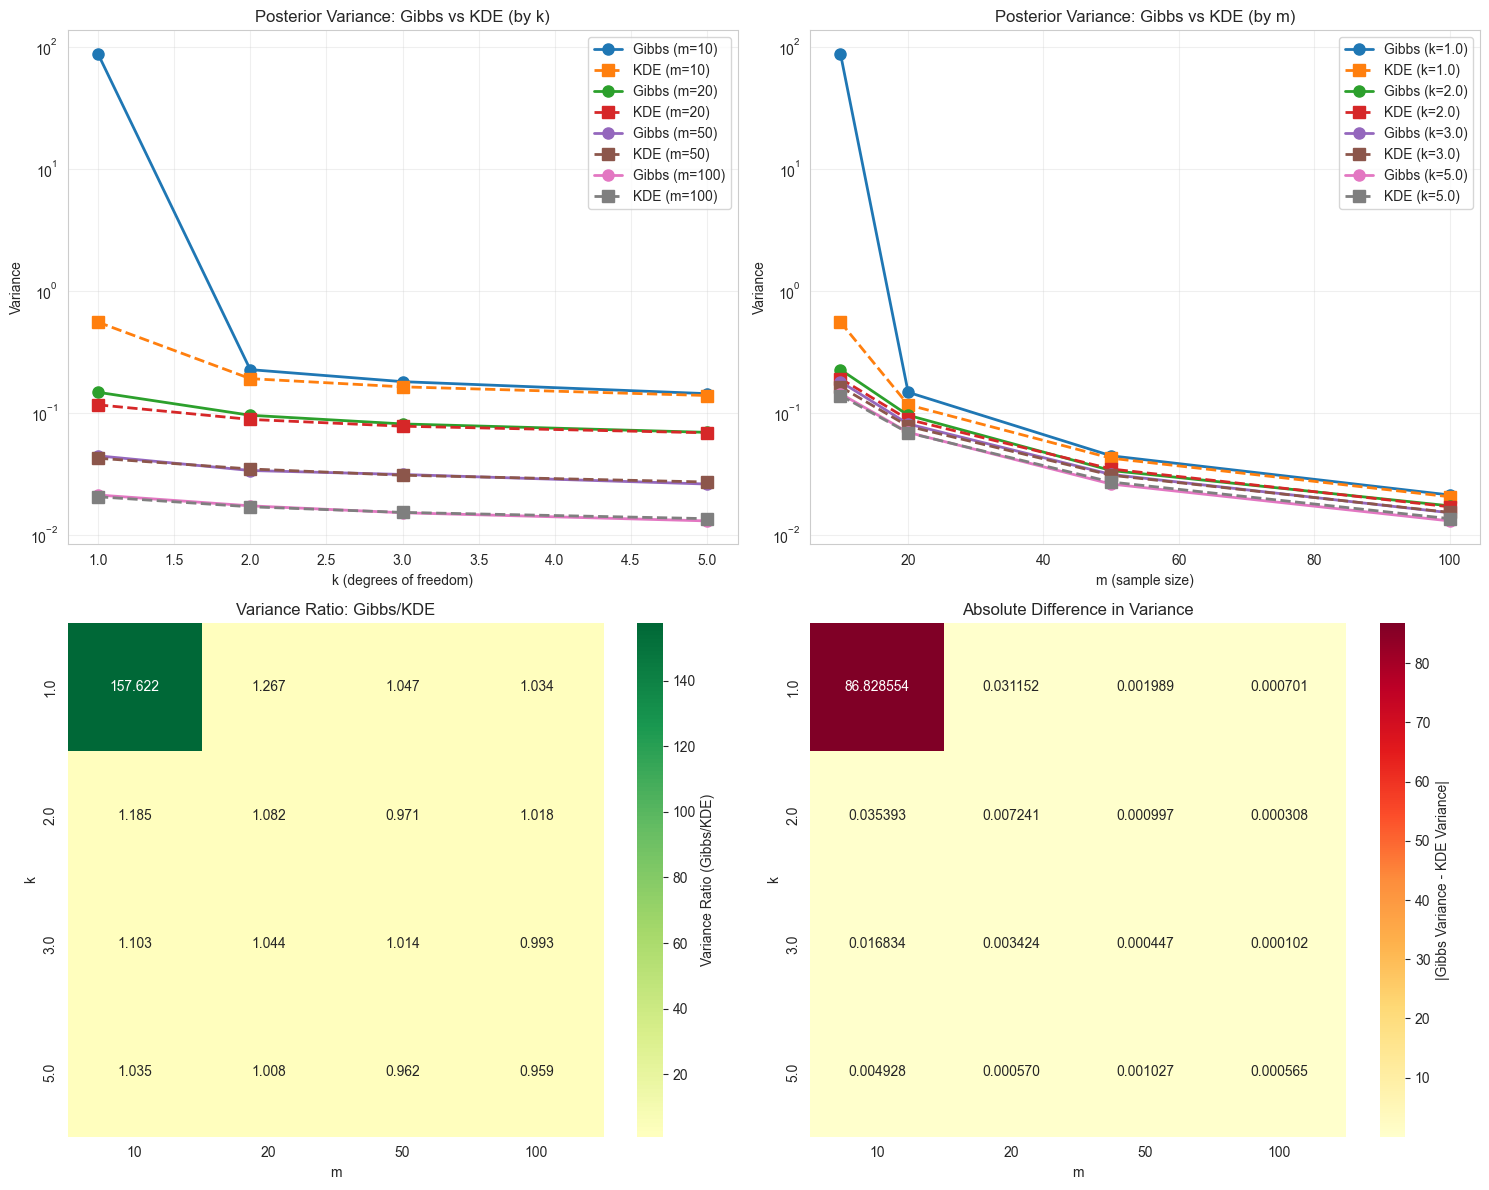

In [7]:
# Visualize variance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Variance comparison by k
for m in ms:
    mask = df_results['m'] == m
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (m={m})', linewidth=2, markersize=8)
    axes[0, 0].plot(df_results[mask]['k'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (m={m})', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('k (degrees of freedom)')
axes[0, 0].set_ylabel('Variance')
axes[0, 0].set_title('Posterior Variance: Gibbs vs KDE (by k)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Variance comparison by m
for k in ks:
    mask = df_results['k'] == k
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
                    'o-', label=f'Gibbs (k={k})', linewidth=2, markersize=8)
    axes[0, 1].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
                    's--', label=f'KDE (k={k})', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('m (sample size)')
axes[0, 1].set_ylabel('Variance')
axes[0, 1].set_title('Posterior Variance: Gibbs vs KDE (by m)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Variance ratio (Gibbs/KDE)
df_results['variance_ratio'] = df_results['gibbs_variance'] / df_results['kde_variance']
pivot_ratio = df_results.pivot(index='k', columns='m', values='variance_ratio')
sns.heatmap(pivot_ratio, annot=True, fmt='.3f', cmap='RdYlGn', center=1.0, 
            ax=axes[1, 0], cbar_kws={'label': 'Variance Ratio (Gibbs/KDE)'})
axes[1, 0].set_title('Variance Ratio: Gibbs/KDE')
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('k')

# Absolute difference in variance
df_results['variance_diff'] = np.abs(df_results['gibbs_variance'] - df_results['kde_variance'])
pivot_diff = df_results.pivot(index='k', columns='m', values='variance_diff')
sns.heatmap(pivot_diff, annot=True, fmt='.6f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': '|Gibbs Variance - KDE Variance|'})
axes[1, 1].set_title('Absolute Difference in Variance')
axes[1, 1].set_xlabel('m')
axes[1, 1].set_ylabel('k')

plt.tight_layout()
plt.show()



DETAILED ANALYSIS: k=1 (Cauchy) Case
  m  gibbs_variance  kde_variance  variance_ratio  variance_diff
 10       87.382937      0.554383      157.622037      86.828554
 20        0.147802      0.116650        1.267058       0.031152
 50        0.044608      0.042619        1.046677       0.001989
100        0.021308      0.020607        1.033996       0.000701


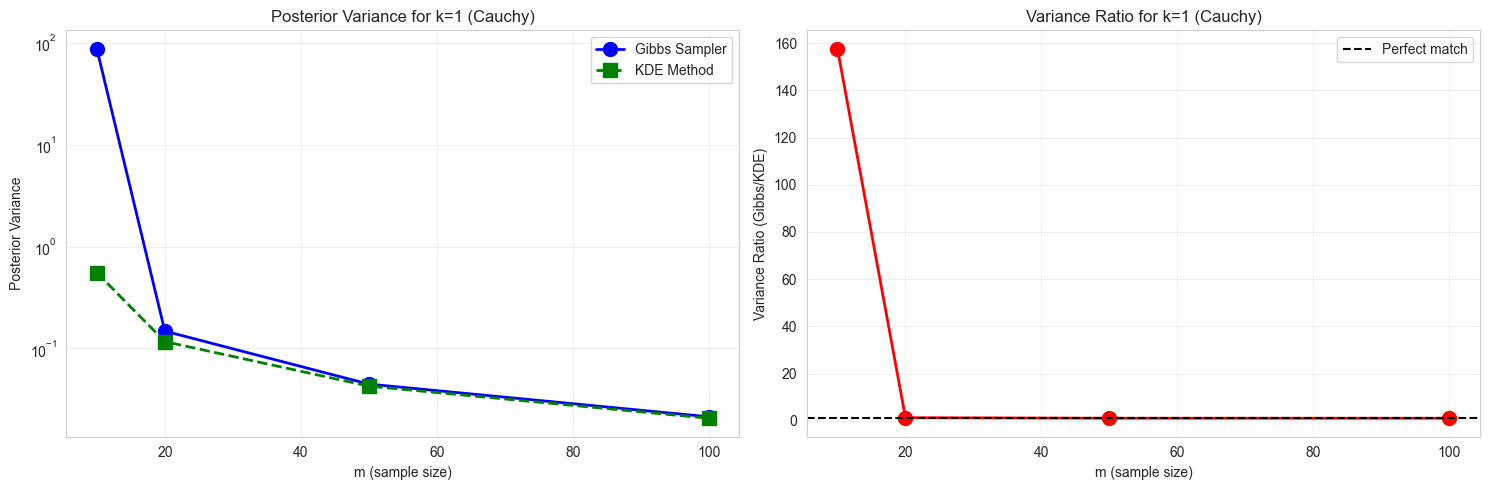

In [8]:
# Focus on k=1 (Cauchy) case - detailed analysis
print("\n" + "="*80)
print("DETAILED ANALYSIS: k=1 (Cauchy) Case")
print("="*80)

cauchy_results = df_results[df_results['k'] == 1.0].copy()
print(cauchy_results[['m', 'gibbs_variance', 'kde_variance', 'variance_ratio', 'variance_diff']].to_string(index=False))

# Plot for k=1 across different m
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

mask = df_results['k'] == 1.0
axes[0].plot(df_results[mask]['m'], df_results[mask]['gibbs_variance'], 
             'o-', label='Gibbs Sampler', linewidth=2, markersize=10, color='blue')
axes[0].plot(df_results[mask]['m'], df_results[mask]['kde_variance'], 
             's--', label='KDE Method', linewidth=2, markersize=10, color='green')
axes[0].set_xlabel('m (sample size)')
axes[0].set_ylabel('Posterior Variance')
axes[0].set_title('Posterior Variance for k=1 (Cauchy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(df_results[mask]['m'], df_results[mask]['variance_ratio'], 
             'o-', linewidth=2, markersize=10, color='red')
axes[1].axhline(1.0, color='black', linestyle='--', label='Perfect match')
axes[1].set_xlabel('m (sample size)')
axes[1].set_ylabel('Variance Ratio (Gibbs/KDE)')
axes[1].set_title('Variance Ratio for k=1 (Cauchy)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
